# Evaluation of Blocking

For each entity we select the largest cluster (block) for that entity. True positives are items that are in the largest cluster and are correctly associated with that entity, false positives are items in the cluster that are not related to the entity and false negatives are items that should be in the cluster but aren't. 

We indicate true positives with $TP$, false positives with $FP$ and false negatives with $FN$,
then we have the equations for $precision$, $recall$ and $f{\text -}measure$:

$$ precision = \frac{TP}{TP + FP} \\ $$
$$ recall = \frac{TP}{TP + FN} \\ $$
$$ f{\text -}measure = \frac{2 \cdot precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 TP + FP + FN} \\ $$


In [4]:
import paths
import json
import evaluation
import numpy as np
import matplotlib.pyplot as plt

In [7]:
algorithms = ["hdbscan", "dbscan", "agglomerative", "kmeans"]

results: dict[str, list[tuple[str, float]]] = {}

for algorithm in algorithms:
    TP = 0
    FP = 0
    FN = 0
    
    evaluation.generate_entity2clusters(algorithm)

    with open(paths.RESULTS_DIR + "/evaluation/" + algorithm + "_entity2clusters.json","r") as file:
        entity2clusters: dict[str, dict[str, list[str]]] = json.load(file)
        
    with open(paths.RESULTS_DIR + "/clustering/" + algorithm + "/" + algorithm + "_clusters.json", "r") as file:
        alg_clusters = json.load(file)
        
        # Remove clusters with id -1 and count the number of false negatives items in those clusters
    for clusters in entity2clusters.values():
        for cluster_id, values in clusters.items():
            if cluster_id == '-1':
                FN += len(values)
                del clusters[cluster_id]
                break
    
    for entity, clusters in entity2clusters.items():
        if len(clusters) == 0:
            continue
        # Get the cluster with the most elements
        max_cluster = max(clusters.values(), key=len)
        
        # Get the id of the cluster with the most elements
        for key,value in clusters.items():
            if len(value) == len(max_cluster):
                max_cluster_id = key
                
        # Calculate False Positives (FP) as elements in the largest cluster that should not be there
        for item in alg_clusters[max_cluster_id]:
            if item not in max_cluster:
                FP += 1   
                                    
        # Calculate True Positives (TP) as elements in the largest cluster
        TP += len(max_cluster)
        
        # Calculate False Negatives (FN) as elements in the other clusters
        for cluster in clusters.values():
            if cluster != max_cluster:
                FN += len(cluster)
     
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results[algorithm] = [
        ("Precision", precision),
        ("Recall", recall),
        ("F-measure", f_measure)
    ]

    print(f"Evaluation for {algorithm} algorithm:")
    print(f"\tPrecision: {precision}")
    print(f"\tRecall: {recall}")
    print(f"\tF-measure: {f_measure}")
    print("\n")

Evaluation for hdbscan algorithm:
	Precision: 0.5727245237375265
	Recall: 0.8296101620674551
	F-measure: 0.6776386404293381


Evaluation for dbscan algorithm:
	Precision: 0.6342268041237114
	Recall: 0.6736749890494963
	F-measure: 0.6533559898045879


Evaluation for agglomerative algorithm:
	Precision: 0.0014458647993418445
	Recall: 0.926850635129216
	F-measure: 0.002887225595882565


Evaluation for kmeans algorithm:
	Precision: 0.0019691966869804177
	Recall: 0.8970652650021901
	F-measure: 0.003929766929130837




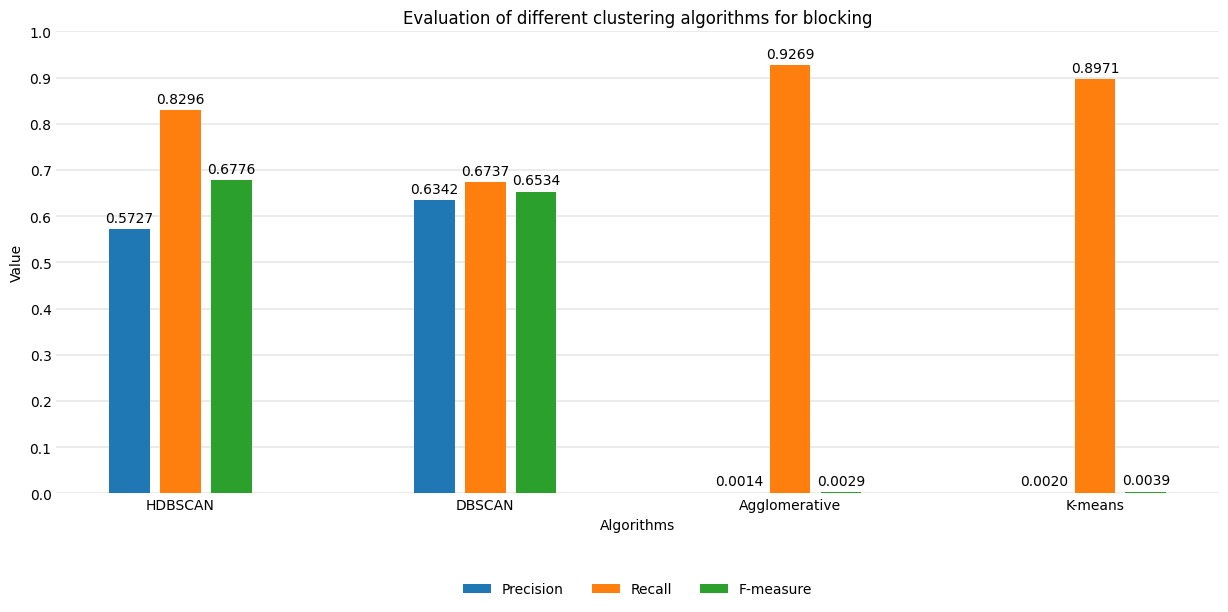

In [12]:
algorithms_names = ["HDBSCAN", "DBSCAN", "Agglomerative", "$k$-means"]

def prepare_data(d):
    n = len(list(d.values())[0])
    out = [list() for _ in range(n)]
    metrics = {}
    for k,v in d.items():
        for i,(u, x) in enumerate(v):
            out[i].append(x)
            metrics[i] = u
    
    return out, metrics, n

def multiple_bar_plot(results: dict[str, dict[str, float]], width, spacing):

    out, metrics, n = prepare_data(results)
    m = len(results)

    fig, ax = plt.subplots(figsize=(15, 6))
    xs = spacing*np.arange(m)
    ax.grid(axis='y', linewidth=0.35, zorder=0)
    for i,v in enumerate(out):
        rect = ax.bar(xs - n*width/2 + width/2 + i*width, v, width*0.8, label=f'{metrics[i]}', zorder=3)
        ax.bar_label(rect, padding=3, fmt='{:,.4f}')

    ax.set(frame_on=False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_ylabel('Value')
    ax.set_xlabel('Algorithms')
    ax.set_title('Evaluation of different clustering algorithms for blocking')
    ax.set_xticks(np.arange(len(algorithms_names))*spacing)
    ax.set_xticklabels(algorithms_names)
    ax.set_yticks([i * 0.10 for i in range(0, 11)])

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(out), frameon=False)

multiple_bar_plot(results, 0.25, 1.5)
plt.show()

## PostProcesing of results from LLM query

In [ ]:
llm_results_file = paths.RESULTS_DIR + "/pairwise_matching/RAW_matching_results_cluster_397.json"

with open(llm_results_file, 'r', encoding='utf-8') as file:
    llm_results_cluster_397: dict[str, list[list[str]]] = json.load(file)

result_cluster_397 = llm_results_cluster_397["397"]

post_processed_results: list[tuple[str, str, str]] = []

for [item1, item2, result] in result_cluster_397:
    if "same" in result:
        post_processed_results.append((item1, item2, "MATCH"))
    elif "different" in result:
        post_processed_results.append((item1, item2, "NO_MATCH"))

post_processed_results_file = paths.RESULTS_DIR + "/pairwise_matching/matching_results_cluster_397_post_processed.json"

with open(post_processed_results_file, "w") as file:
    json.dump(post_processed_results, file, indent=4)




In [ ]:
TP = 0
FP = 0
FN = 0

In [ ]:
entity2cluster397: list[str] = entity2clusters["ENTITY#011"]["397"]

for item1, item2, result in post_processed_results:
    if result == "MATCH":
        if item1 in entity2cluster397 and item2 in entity2cluster397:
            TP += 1
        else:
            FP += 1
    elif item1 in entity2cluster397 and item2 in entity2cluster397:
        FN += 1

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-measure: {f_measure}")

Precision: 0.7
Recall: 1.0
F-measure: 0.8235294117647058


# Siamese Network Evaluation

In [1]:
import torch
import json
import paths
import evaluation
from pairwise_matching_siamese import SiameseDataset
from pairwise_matching_siamese import SiameseNetwork
from pairwise_matching_siamese import generate_pairs
from torch.utils.data import DataLoader

/home/prox/linkage-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
embeddings = json.load(open(paths.RESULTS_DIR + "/embeddings/embeddings_distilbert_base_uncased_preprocessed.json"))
entity2clusters = json.load(open(paths.RESULTS_DIR + "/evaluation/entity2clusters.json"))

# Load the model and optimizer state
model = SiameseNetwork(embedding_dim=768, hidden_dim=256)
model.load_state_dict(torch.load(paths.MODELS_DIR + "/siamese_net/siamese_model_final.pth"))

pairs, labels = generate_pairs(entity2clusters)

dataset = SiameseDataset(pairs, labels, embeddings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model.eval()  # Switch to evaluation mode

precision, recall, f1_score = evaluation.evaluate_siamese_model(model, dataloader, threshold=0.00002)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

Generated 4285091 pairs: 11261 positive pairs and 4273830 negative pairs
Precision: 0.349763986690397
Recall: 0.8027706242784832
F1-Score: 0.48723960438731245
